<a href="https://colab.research.google.com/github/TonyStone23/UAV-for-Concrete-Crack-Inspection/blob/main/Bridge_Crack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concrete Crack Detection
* CSC-499, SCSU
* Tony Stone
* Dataset: Concrete Crack Detection Dataset from Mendeley Data
* Model: CNN (EfficientNet + B0) from tensorflow

* Resources:
  * TensorFlow Documentation: https://www.tensorflow.org/tutorials/images/classification#create_a_dataset
  * Mendeley Dataset: https://data.mendeley.com/datasets/5y9wdsg2zt/2
  * GitHub Example 1: https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/16_cnn_cifar10_small_image_classification/cnn_cifar10_dataset.ipynb

  * GitHub Example 2: https://github.com/norahb/Image_classificaiton_EfficientNet/blob/main/Binary_Image_Classification_EfficientNet.ipynb
* Additional Notes
  * Initiate runtime with GPU

In [24]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import shutil
import random as r

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras import models
from google.colab import drive
drive.mount('/content/drive')

r.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
data_set = "Bridge Cracks"

In [26]:
# Collect images from origional Mendeley Dataset, and create a Subset
source_directory = f"/content/drive/MyDrive/{data_set}"
destination_directory = "/content/Subset"

classes = ["Negative", "Positive"]

# number of images per class to keep
n_samples = 1000

# Clear destination if it already exists
if os.path.exists(destination_directory):
    shutil.rmtree(destination_directory)
os.makedirs(destination_directory)

for cls in classes:
    src_class_dir = os.path.join(source_directory, cls)
    dst_class_dir = os.path.join(destination_directory, cls)
    images = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    r.shuffle(images)

    os.makedirs(dst_class_dir, exist_ok=True)

    # Limit to n_samples if class has more images
    images = images[:n_samples]

    # Copy files
    for img in images:
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

print("Subset created at:", destination_directory)

Subset created at: /content/Subset


In [27]:
data_dir = destination_directory

batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
['Negative', 'Positive']


In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
# Load a Pre-Trained Model
baseModel = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False)
baseModel.trainable = False

inputs = tf.keras.Input(shape = (224, 224, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = baseModel(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = models.Model(inputs, outputs)

In [30]:
# Compile Model
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                  'accuracy',
                  tf.keras.metrics.TruePositives(name="TP"),
                  tf.keras.metrics.FalsePositives(name="FP"),
                  tf.keras.metrics.FalseNegatives(name="FN"),
                  tf.keras.metrics.TrueNegatives(name="TN"),
                  tf.keras.metrics.AUC(name = "ROC", curve='ROC', num_thresholds = 30)
                  ])


In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [32]:
# Train Model
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - FN: 210.7308 - FP: 128.6538 - ROC: 0.5770 - TN: 317.6923 - TP: 204.4615 - accuracy: 0.5647 - loss: 0.6830 - val_FN: 15.0000 - val_FP: 13.0000 - val_ROC: 0.9733 - val_TN: 169.0000 - val_TP: 203.0000 - val_accuracy: 0.9300 - val_loss: 0.4512
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - FN: 46.1154 - FP: 47.8846 - ROC: 0.9581 - TN: 389.9615 - TP: 377.5769 - accuracy: 0.8899 - loss: 0.4214 - val_FN: 13.0000 - val_FP: 10.0000 - val_ROC: 0.9841 - val_TN: 172.0000 - val_TP: 205.0000 - val_accuracy: 0.9425 - val_loss: 0.3130
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - FN: 35.0385 - FP: 34.5769 - ROC: 0.9779 - TN: 402.2308 - TP: 389.6923 - accuracy: 0.9180 - loss: 0.3078 - val_FN: 17.0000 - val_FP: 6.0000 - val_ROC: 0.9874 - val_TN: 176.0000 - val_TP: 201.0000 - val_accuracy: 0.9425 - val_loss: 0.2553
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - FN: 40.9231 - FP: 28.3077 - ROC: 0.9771 - TN: 412.7692 - TP: 379.5385 - ac

In [33]:
#model.export("/content/drive/MyDrive/CNN_UAV")


In [57]:

ttp = history.history['TP']
tfp = history.history['FP']
tfn = history.history['FN']
ttn = history.history['TN']

vtp = history.history['val_TP']
vfp = history.history['val_FP']
vfn = history.history['val_FN']
vtn = history.history['val_TN']

import pandas as pd
CM_components = {"Training": [int(ttp[-1]), int(tfp[-1]), int(tfn[-1]), int(ttn[-1])],
                 "Validation": [int(vtp[-1]), int(vfp[-1]), int(vfn[-1]), int(vtn[-1])]}
CM_components = pd.DataFrame(CM_components, index = ["TP", "FP", "FN", "TN"])
print(CM_components)

    Training  Validation
TP       741         208
FP        31           5
FN        41          10
TN       787         177
<class 'pandas.core.frame.DataFrame'>


In [46]:
ms = ["Precision", "Negative Predictive Value", "Recall", "Specificity", "Accuracy", "F1"]
# Training Metrics
t_pre = [ttp[i]/(ttp[i] + tfp[i]) for i in range(epochs)]
t_npre = [ttn[i]/(ttn[i] + tfn[i]) for i in range(epochs)]
t_rec = [ttp[i]/(ttp[i] + tfn[i]) for i in range(epochs)]
t_spec = [ttn[i]/(ttn[i] + tfp[i]) for i in range(epochs)]
t_acc = [(ttp[i]+ttn[i])/(ttp[i]+ ttn[i] + tfp[i] + tfn[i]) for i in range(epochs)]
t_f1 = [2* (t_pre[i] * t_rec[i])/(t_pre[i] + t_rec[i]) for i in range(epochs)]
trainMetrics = [t_pre, t_npre, t_rec, t_spec, t_acc, t_f1]

# Validation Metrics
v_pre = [vtp[i]/(vtp[i] + vfp[i]) for i in range(epochs)]
v_npre = [vtn[i]/(vtn[i] + vfn[i]) for i in range(epochs)]
v_rec = [vtp[i]/(vtp[i] + vfn[i]) for i in range(epochs)]
v_spec = [vtn[i]/(vtn[i] + vfp[i]) for i in range(epochs)]
v_acc = [(vtp[i]+vtn[i])/(vtp[i]+ vtn[i] + vfp[i] + vfn[i]) for i in range(epochs)]
v_f1 = [2* (v_pre[i] * v_rec[i])/(v_pre[i] + t_rec[i]) for i in range(epochs)]
valMetrics = [v_pre, v_npre, v_rec, v_spec, v_acc, v_f1]

metrics = {"Training Case": [t_pre[-1], t_npre[-1], t_rec[-1], t_spec[-1], t_acc[-1], t_f1[-1]],
           "Validation Case": [v_pre[-1], v_npre[-1], v_rec[-1], v_spec[-1], v_acc[-1], v_f1[-1]]}

metrics = pd.DataFrame(metrics, index = ["Precision", "Negative Predictive Value", "Recall", "Specificity", "Accuracy", "F1"])
print(metrics)

                           Training Case  Validation Case
Precision                       0.959845         0.976526
Negative Predictive Value       0.950483         0.946524
Recall                          0.947570         0.954128
Specificity                     0.962103         0.972527
Accuracy                        0.955000         0.962500
F1                              0.953668         0.968487


In [74]:
"""
# ROC Curve
image_path = f"/content/drive/MyDrive/{data_set}"
def ROC(thresholds):
    for i in range(thresholds):


train_true = np.concatenate([y for x, y in train_true_data], axis = 0)
val_true = np.concatenate([y for x, y in val_true_data], axis = 0)
train_pred = (model.predict(train_true_data, verbose = 0) >=.5).squeeze()
val_pred = (model.predict(val_true_data, verbose = 0) >=.5).squeeze()
print(train_true.shape)
print(train_pred.shape)


from sklearn.metrics import auc, roc_curve as roc
tfpr, ttpr, thresholds = roc(train_true, train_pred)
tauc = auc(tfpr, ttpr)

vfpr, vtpr, thresholds = roc(val_true, val_pred)
vauc = auc(vfpr, vtpr)

plt.figure(figsize = (6, 6))
plt.plot([0, 1],[0, 1], label = "Random Classifier", linestyle = '--',color = 'gray')
plt.plot(tfpr, ttpr, label = f'Training Case AUC: {tauc:.04}', color = 'blue' )
plt.plot(vfpr, vtpr, label = f'Validation Case AUC: {vauc:.04}', color = 'red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic Curve")
plt.legend()
plt.show()
"""

'\n# ROC Curve\nimage_path = f"/content/drive/MyDrive/{data_set}"\ndef ROC(thresholds):\n    for i in range(thresholds):\n\n\ntrain_true = np.concatenate([y for x, y in train_true_data], axis = 0)\nval_true = np.concatenate([y for x, y in val_true_data], axis = 0)\ntrain_pred = (model.predict(train_true_data, verbose = 0) >=.5).squeeze()\nval_pred = (model.predict(val_true_data, verbose = 0) >=.5).squeeze()\nprint(train_true.shape)\nprint(train_pred.shape)\n\n\nfrom sklearn.metrics import auc, roc_curve as roc\ntfpr, ttpr, thresholds = roc(train_true, train_pred)\ntauc = auc(tfpr, ttpr)\n\nvfpr, vtpr, thresholds = roc(val_true, val_pred)\nvauc = auc(vfpr, vtpr)\n\nplt.figure(figsize = (6, 6))\nplt.plot([0, 1],[0, 1], label = "Random Classifier", linestyle = \'--\',color = \'gray\')\nplt.plot(tfpr, ttpr, label = f\'Training Case AUC: {tauc:.04}\', color = \'blue\' )\nplt.plot(vfpr, vtpr, label = f\'Validation Case AUC: {vauc:.04}\', color = \'red\')\nplt.xlabel(\'False Positive Rate\')\

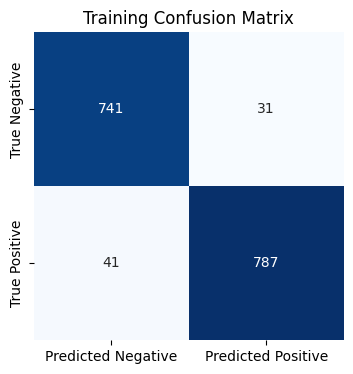

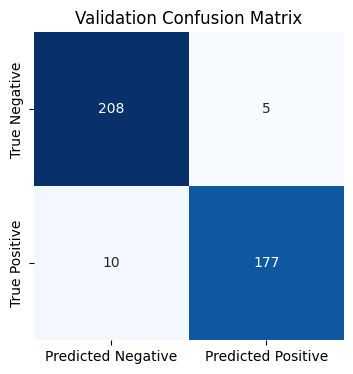

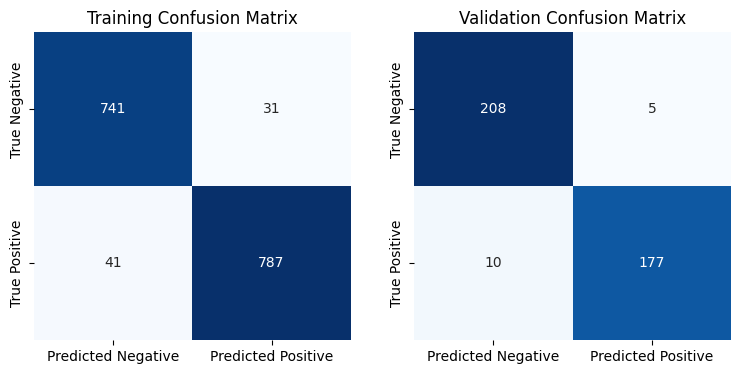

In [70]:
# Confusion Matrix
# Plotted separately
import seaborn as sns
xlabels = ['Predicted Negative', 'Predicted Positive']
ylabels = ['True Negative', 'True Positive']
t_conf = CM_components["Training"].tolist()
t_conf = [t_conf[:2], t_conf[2:]]

plt.figure(figsize = (4, 4))
sns.heatmap(t_conf,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            cbar = False,
            xticklabels = xlabels,
            yticklabels = ylabels)
plt.title('Training Confusion Matrix')
plt.show()
plt.figure(figsize = (4, 4))
v_conf = CM_components["Validation"].tolist()
v_conf = [v_conf[:2], v_conf[2:]]
sns.heatmap(v_conf,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            cbar = False,
            xticklabels = xlabels,
            yticklabels = ylabels)
plt.title('Validation Confusion Matrix')
plt.show()

#Plotted together
plt.figure(figsize = (9, 4))
plt.subplot(1, 2, 1)
sns.heatmap(t_conf,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            cbar = False,
            xticklabels = xlabels,
            yticklabels = ylabels)
plt.title('Training Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(v_conf,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            cbar = False,
            xticklabels = xlabels,
            yticklabels = ylabels)
plt.title('Validation Confusion Matrix')
plt.show()

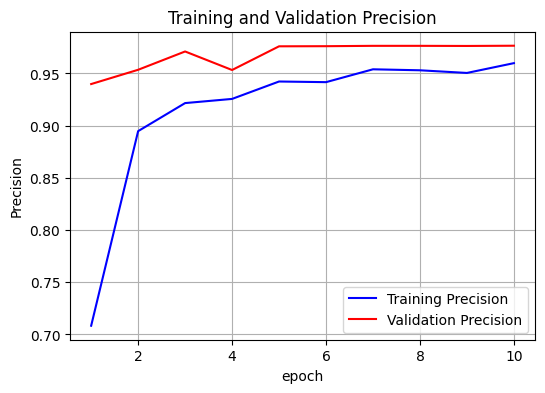

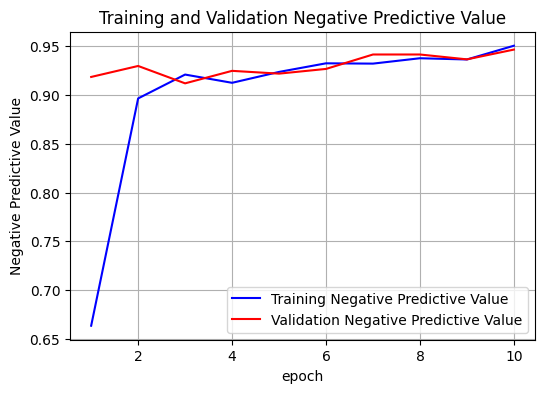

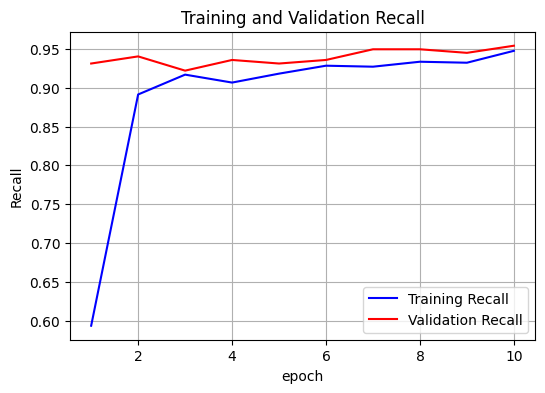

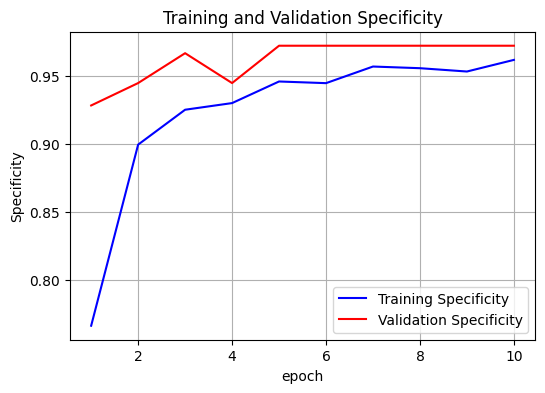

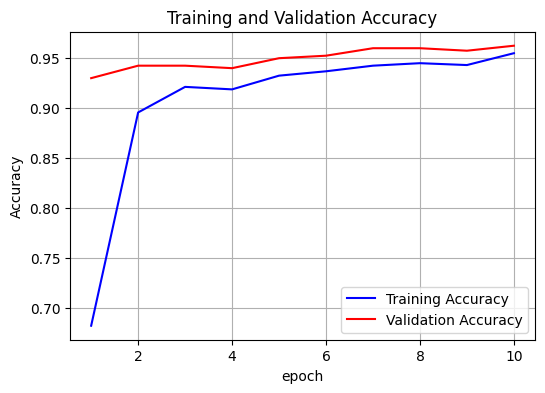

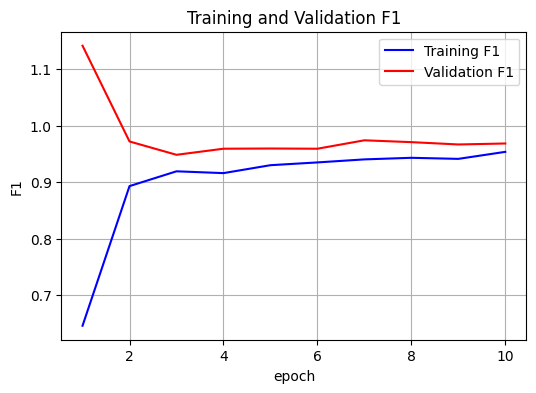

In [71]:
epochs_range = range(1, epochs+1)
for m in range(len(ms)):
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, trainMetrics[m], label=f'Training {ms[m]}', color = 'blue')
    plt.plot(epochs_range, valMetrics[m], label=f'Validation {ms[m]}', color = 'red')
    plt.legend()
    plt.ylabel(f'{ms[m]}')
    plt.xlabel('epoch')
    plt.title(f'Training and Validation {ms[m]}')
    plt.grid(True)
    plt.show()

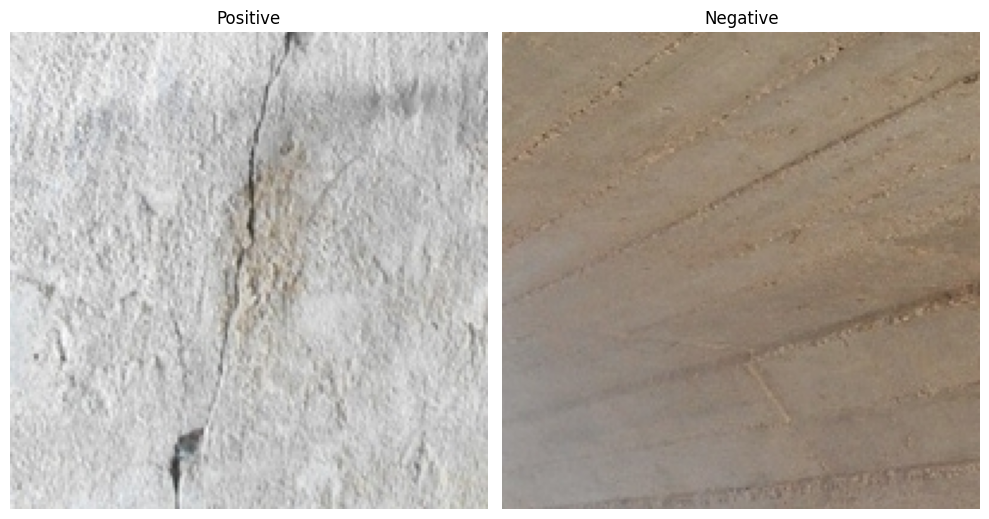

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


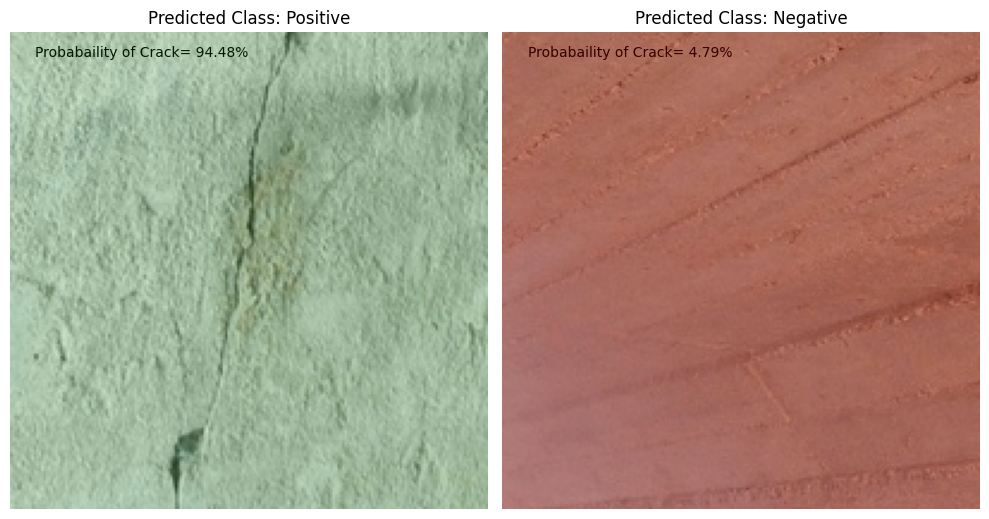

In [72]:
# Test on Random Images for Visual
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image # type: ignore

# Random Image with Crack
positive_image_path = f"/content/drive/MyDrive/Bridge Cracks/Positive/{r.randint(0, 100):04}.jpg"
# Random Image without Crack
negative_image_path = f"/content/drive/MyDrive/Bridge Cracks/Negative/{r.randint(0, 100):04}.jpg"

plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(positive_image_path))
plt.title("Positive")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(negative_image_path))
plt.title("Negative")
plt.axis('off')
plt.tight_layout()
plt.show()

pos_crack = image.load_img(positive_image_path, target_size=(img_width, img_height))
pos_crack_array = image.img_to_array(pos_crack)
pos_crack_array = np.expand_dims(pos_crack_array, axis=0)

neg_crack = image.load_img(negative_image_path, target_size=(img_width, img_height))
neg_crack_array = image.img_to_array(neg_crack)
neg_crack_array = np.expand_dims(neg_crack_array, axis=0)

import matplotlib.patches as patches

predictions = model.predict(pos_crack_array)
predicted_class = class_names[0] if predictions[0][0] < 0.5 else class_names[1]
hue = 'red' if predictions[0][0] < 0.5 else 'green'
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(positive_image_path))
ax = plt.gca()
overlay = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, facecolor= hue, alpha=0.2, zorder=10)
ax.add_patch(overlay)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.text(10, 10, f"Probabaility of Crack= {float(predictions[0][0])*100:.2f}%", fontsize = 10)


predictions = model.predict(neg_crack_array)
predicted_class = class_names[0] if predictions[0][0] < 0.5 else class_names[1]
hue = 'red' if predictions[0][0] < 0.5 else 'green'
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(negative_image_path))
ax = plt.gca()
overlay = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, facecolor= hue, alpha=0.2, zorder=10)
ax.add_patch(overlay)
plt.title(f"Predicted Class: {predicted_class}")
plt.text(10, 10, f"Probabaility of Crack= {float(predictions[0][0])*100:.2f}%", fontsize = 10)
plt.axis('off')
plt.tight_layout()
plt.show()